## Environment

In [2]:
import os
os.chdir('/app')

In [23]:
import torch
import config
import dataset
from model import BERTBaseUncased
from train import train_fn, eval_fn
from utils import print_current_config
from beautifultable import BeautifulTable as BT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data.distributed import DistributedSampler


""" CONFIG """
CUDA = torch.cuda.is_available()
N_GPU = torch.cuda.device_count()
DEVICE = 'cuda' if CUDA else 'cpu'
WORKERS = torch.multiprocessing.cpu_count()
print_current_config(CUDA, N_GPU, DEVICE, WORKERS)

Environment Settings
+---------+----------------------+
| Python  |        3.7.7         |
+---------+----------------------+
| PyTorch |        1.5.0         |
+---------+----------------------+
|  GPUs   |          1           |
+---------+----------------------+
|  Cores  |          6           |
+---------+----------------------+
| Device  | Tesla P100-PCIE-16GB |
+---------+----------------------+


In [4]:
device = torch.device(DEVICE)

## Data

In [12]:
df1 = pd.read_csv('data/jigsaw-toxic-comment-train.csv', usecols=['comment_text', 'toxic'])
df2 = pd.read_csv('data/jigsaw-unintended-bias-train.csv', usecols=['comment_text', 'toxic'], engine='python')

In [17]:
df1.head(2)

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


In [18]:
df2.head(2)

,comment_text,toxic
0,"This is so cool. It's like, 'would you want yo...",0.0
1,Thank you!! This would make my life a lot less...,0.0


In [20]:
print('Total training samples = {} + {} = {}'.format(df1.shape[0], df2.shape[0], df1.shape[0] + df2.shape[0]))

Total training samples = 223549 + 1737739 = 1961288


In [15]:
df_train = pd.concat([df1,df2], axis=0).reset_index(drop=True)

In [16]:
df_valid = pd.read_csv('data/validation.csv')

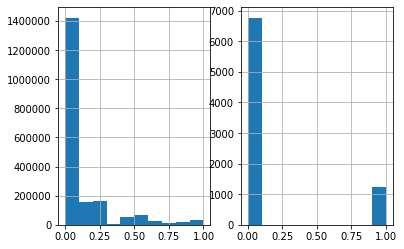

In [25]:
fig, axs = plt.subplots(ncols=2)
df_train.toxic.hist(ax=axs[0])
df_valid.toxic.hist(ax=axs[1])

## Dataloaders

In [21]:
train_dataset = dataset.BERTDataset(
    comment=df_train.comment_text.values,
    target=df_train.toxic.values
)

In [26]:
valid_dataset = dataset.BERTDataset(
    comment=df_valid.comment_text.values,
    target=df_valid.toxic.values
)

In [27]:
drop_last=False
train_sampler, valid_sampler = None, None
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=config.TRAIN_BATCH_SIZE,
    num_workers=4,
    drop_last=drop_last,
    sampler=train_sampler
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config.VALID_BATCH_SIZE,
    num_workers=1,
    drop_last=drop_last,
    sampler=valid_sampler
)

## Model

In [35]:
model = BERTBaseUncased()
model.to(device)

BERTBaseUncased(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

## Training

### Training Config

In [36]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = config.LR
num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
# TODO: why do the LR increases because of a distributed training ?
if config.TPUs:
    num_train_steps /= n_TPUs
    lr *= n_TPUs

In [37]:
optimizer = AdamW(optimizer_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

if not config.TPUs:
    if N_GPU > 1:
        model = nn.DataParallel(model)

### Training Loop

In [39]:
best_score = 0
    
for epoch in range(config.EPOCHS):

    if config.TPUs:
        train_loader = pl.ParallelLoader(train_data_loader, [device])
        valid_loader = pl.ParallelLoader(valid_data_loader, [device])
        train_fn(train_loader.per_device_loader(device), model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_loader.per_device_loader(device), model, device)

    else:
        train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_data_loader, model, device)

    targets = np.array(targets) >= 0.5 # TODO: why ?
    auc_score = metrics.roc_auc_score(targets, outputs)

    # Save if best
    print(f"AUC Score = {auc_score}")
    if auc_score > best_score:
        if not config.TPUs:
            torch.save(model.state_dict(), config.MODEL_PATH)
        else:
            xm.save(model.state_dict(), config.MODEL_PATH)
        best_score = auc_score

  0%|          | 0/245161 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
  0%|          | 464/245161 [01:00<8:55:08,  7.62it/s]

KeyboardInterrupt: 